In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm

import os 

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.set_printoptions(sci_mode=False)
batch_size = 128
workers = 0

In [3]:
### class needed before model called 
latent_dim = 100
output_dim = 10
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        n = 300
        self.l1 = nn.Linear(latent_dim+2,n)
        self.l2 = nn.Linear(n,n)
        self.l3 = nn.Linear(n,n)
        self.l4 = nn.Linear(n,n)
        self.l5 = nn.Linear(n,n)
        self.l6 = nn.Linear(n,n)
        self.l7 = nn.Linear(n,n)
        self.l8 = nn.Linear(n,n)
        self.l9 = nn.Linear(n,output_dim)
        self.activation = nn.LeakyReLU(negative_slope=0.1)
        
        self.bn2 = nn.BatchNorm1d(n)
        self.bn3 = nn.BatchNorm1d(n)
        self.bn4 = nn.BatchNorm1d(n)
        self.bn5 = nn.BatchNorm1d(n)
        self.bn6 = nn.BatchNorm1d(n)
        self.bn7 = nn.BatchNorm1d(n)
        self.bn8 = nn.BatchNorm1d(n)
        
    def forward(self, x):
        x = x.view(-1, latent_dim+2)
        x = self.activation(self.l1(x))
        x = self.bn2(self.activation(self.l2(x)))
        x = self.bn3(self.activation(self.l3(x)))
        x = self.bn4(self.activation(self.l4(x)))
        x = self.bn5(self.activation(self.l5(x)))
        x = self.bn6(self.activation(self.l6(x)))
        x = self.bn7(self.activation(self.l7(x)))
        x = self.bn8(self.activation(self.l8(x)))
        return self.l9(x)

    
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        n = 300
        self.l1 = nn.Linear(output_dim+2,n)
        self.l2 = nn.Linear(n,n)
        self.l3 = nn.Linear(n,n)
        self.l4 = nn.Linear(n,n)
        self.l5 = nn.Linear(n,n)
        self.l6 = nn.Linear(n,n)
        self.l7 = nn.Linear(n,n)
        self.l8 = nn.Linear(n,n)
        self.l9 = nn.Linear(n,1)
        self.activation = nn.LeakyReLU(negative_slope=0.1)
        
    def forward(self, x):
        x = self.activation(self.l1(x))
        x = self.activation(self.l2(x))
        x = self.activation(self.l3(x))
        x = self.activation(self.l4(x))
        x = self.activation(self.l5(x))
        x = self.activation(self.l6(x))
#         x = self.activation(self.l7(x))
#         x = self.activation(self.l8(x))
        return torch.sigmoid(self.l9(x))
    

In [34]:
### epoch 1000
# G = torch.load('./models1115/G_final_1115')
# D = torch.load('./models1115/D_final_1115')

### epoch 500
G = torch.load('./models1115/G500')
D = torch.load('./models1115/D500')

G.eval()
D.eval()

Discriminator(
  (l1): Linear(in_features=11, out_features=300, bias=True)
  (l2): Linear(in_features=300, out_features=300, bias=True)
  (l3): Linear(in_features=300, out_features=300, bias=True)
  (l4): Linear(in_features=300, out_features=300, bias=True)
  (l5): Linear(in_features=300, out_features=300, bias=True)
  (l6): Linear(in_features=300, out_features=300, bias=True)
  (l7): Linear(in_features=300, out_features=300, bias=True)
  (l8): Linear(in_features=300, out_features=300, bias=True)
  (l9): Linear(in_features=300, out_features=1, bias=True)
  (activation): LeakyReLU(negative_slope=0.1)
)

In [5]:
#train 할 때 사용한 mean and std. 불러오기 
env_map2 = torch.load('./env_map2')

In [6]:
env_map2

tensor([[    6.4717,     1.0938],
        [   36.4905,     8.1167],
        [   39.4441,    21.3063],
        [  117.1471,    49.1100],
        [  184.2496,   134.4940],
        [   27.8329,    16.4006],
        [    0.5144,     0.1069],
        [   29.8543,    20.9866],
        [   92.2349,    94.7402],
        [   55.8039,    24.4596],
        [  203.1340,    42.2054],
        [    0.0000,     0.0000]], dtype=torch.float64)

In [7]:
# normalize 하는법 
def solvex(x,u,s):
    output = ((x-u)/s)
    return output

#  denormalization
def invsolve(x,u,s):
    element = (x*s)+u
    return element 

In [8]:
########### user parameters #############
# PH0 = 7.5
# temp0 = 40.0
# PH0 = 5.5
# temp0 = 30.0

# PH0 = 6.9
# temp0 = 27.0

# PH0 = 6.0
# temp0 = 25.0

PH0 = 6.0
temp0 = 37.0

control_motility_idx = [4,8] ## motility parameter indices to control

# motility0 = [0.2678, 33.5697]     ## current experimental motility values
# motility0 = [0.2921876, 35.829865]     ## current experimental motility values
# motility0 = [0.3490, 38.6859]     ## current experimental motility values
# motility0 = [0.2787, 37.72]     ## current experimental motility values
motility0 = [0.2503, 30.6101]     ## current experimental motility values

# motility_d = [0.26296884, 32.2468785] ## desired motility values
# motility_d = [0.2921876*0.9, 35.829865*1.0] ## desired motility values
# motility_d = [0.3490 * 0.9, 38.6859 * 0.9] ## desired motility values
# motility_d = [0.3004, 33.67] ## desired motility values
motility_d = [0.2503 * 1.2, 30.6101 * 1.1] ## desired motility values


In [9]:
# ########### user parameters #############
# PH0 = 4.3
# temp0 = 36.9

# control_motility_idx = [4,8] ## motility parameter indices to control

# motility0 = [0.1635, 35.8298]     ## current experimental motility values

# motility_d = [0.26296884, 32.2468785] ## desired motility values
# # motility_d = [0.2921876, 32.2468785] ## desired motility values

In [10]:
### normalize inputs (PH & temp.)
mean = env_map2[:,0]
std = env_map2[:,1]

PH0_normalized = solvex(PH0, mean[0], std[0])
temp0_normalized = solvex(temp0, mean[1], std[1])

x0 = torch.Tensor([PH0_normalized, temp0_normalized])
x0 = nn.Parameter(x0)

In [11]:
print(mean)
print(std)

tensor([  6.4717,  36.4905,  39.4441, 117.1471, 184.2496,  27.8329,   0.5144,
         29.8543,  92.2349,  55.8039, 203.1340,   0.0000], dtype=torch.float64)
tensor([    1.0938,     8.1167,    21.3063,    49.1100,   134.4940,    16.4006,
            0.1069,    20.9866,    94.7402,    24.4596,    42.2054,     0.0000],
       dtype=torch.float64)


In [12]:
## define y0
y00 = solvex(motility0[0], mean[control_motility_idx[0]+2], std[control_motility_idx[0]+2])
y01 = solvex(motility0[1], mean[control_motility_idx[1]+2], std[control_motility_idx[1]+2])

y0 = torch.Tensor([y00, y01])


## define y_d
y_d0 = solvex(motility_d[0], mean[control_motility_idx[0]+2], std[control_motility_idx[0]+2])
y_d1 = solvex(motility_d[1], mean[control_motility_idx[1]+2], std[control_motility_idx[1]+2])

y_d = torch.Tensor([y_d0, y_d1])
print(y0, y_d, y_d - y0)

tensor([-2.4704, -4.0877]) tensor([-2.0020, -4.0152]) tensor([0.4683, 0.0725])


In [13]:
## generator input 생성
nSample = 10000

ginput_test =torch.cat([x0.repeat(nSample,1), torch.randn(nSample,latent_dim)],dim=1).float().to(device)


In [14]:
## generator output 계산
goutput = G(ginput_test)

y0_est = goutput[:, control_motility_idx].mean(dim=0)
print(y0_est)
y0_est0 = invsolve(y0_est[0], mean[control_motility_idx[0]+2], std[control_motility_idx[0]+2])
y0_est1 = invsolve(y0_est[1], mean[control_motility_idx[1]+2], std[control_motility_idx[1]+2])
print([y0_est0.item(), y0_est1.item()])

tensor([ 1.0015, -0.0743], device='cuda:0', grad_fn=<MeanBackward1>)
[0.6214113787944626, 199.99853390116405]


In [15]:
optimizer = optim.Adam([x0], lr=0.00001, weight_decay=0.000001)
optimizer.zero_grad()

y0_est[0].backward()

print(x0.grad)
J0 = x0.grad.clone() # Jacobian row 1

tensor([0.2582, 0.9490])


In [16]:
## generator output 계산
goutput = G(ginput_test)

y0_est = goutput[:, control_motility_idx].mean(dim=0)
print(y0_est)

tensor([ 1.0015, -0.0743], device='cuda:0', grad_fn=<MeanBackward1>)


In [17]:
optimizer = optim.Adam([x0], lr=0.00001, weight_decay=0.000001)
optimizer.zero_grad()

y0_est[1].backward()

print(x0.grad)
J1 = x0.grad # Jacobian row 2

tensor([0.0401, 0.1620])


In [18]:
## Jacobian and its inverse
J = torch.cat([J0.view(1,2), J1.view(1,2)], dim=0)

# regularization
if torch.linalg.cond(J) < 1e-3:
    J[0,0] += 1e-3
    J[1,1] += 1e-3
    print('Regularized!')

invJ = torch.linalg.inv(J)

In [19]:
## compute target PH and temp
stepsize = 0.5
x = x0.detach() + stepsize * torch.matmul(invJ, (y_d - y0).view(2,1)).view(2)

PH1 = (x[0] * std[0] + mean[0]).item()
temp1 = (x[1] * std[1] + mean[1]).item()

print([PH1, temp1])

[7.024468181588986, 36.93406822968191]


In [20]:
# x1 = x0
# # x1 = x0 + torch.matmul(invJ, (y_d - y0).view(2,1)).view(2)

# ## generator input 생성
# nSample = 10000

# ginput_test =torch.cat([x1.repeat(nSample,1), torch.randn(nSample,latent_dim)],dim=1).float().to(device)

# ## generator output 계산
# goutput = G(ginput_test)

# y0_est = goutput[:, control_motility_idx].mean(dim=0)
# print(y0_est)
# y0_est0 = invsolve(y0_est[0], mean[control_motility_idx[0]+2], std[control_motility_idx[0]+2])
# y0_est1 = invsolve(y0_est[1], mean[control_motility_idx[1]+2], std[control_motility_idx[1]+2])
# print([y0_est0.item(), y0_est1.item()])

In [21]:
G

Generator(
  (l1): Linear(in_features=102, out_features=300, bias=True)
  (l2): Linear(in_features=300, out_features=300, bias=True)
  (l3): Linear(in_features=300, out_features=300, bias=True)
  (l4): Linear(in_features=300, out_features=300, bias=True)
  (l5): Linear(in_features=300, out_features=300, bias=True)
  (l6): Linear(in_features=300, out_features=300, bias=True)
  (l7): Linear(in_features=300, out_features=300, bias=True)
  (l8): Linear(in_features=300, out_features=300, bias=True)
  (l9): Linear(in_features=300, out_features=9, bias=True)
  (activation): LeakyReLU(negative_slope=0.1)
  (bn2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn6): BatchNorm1d(300, eps=1e-05,

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


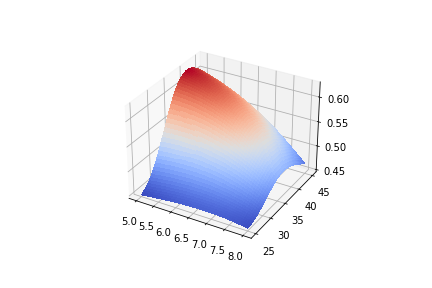

<IPython.core.display.Javascript object>


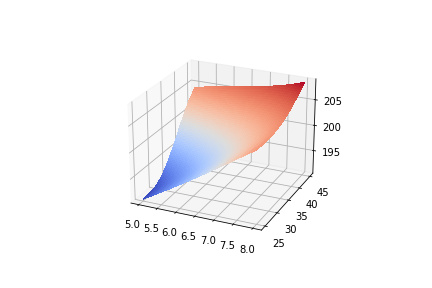

In [35]:
# import matplotlib.pyplot as plt
# from matplotlib import cm
# from matplotlib.ticker import LinearLocator
# import numpy as np

%matplotlib inline
%matplotlib notebook

## plot model

# input and output variables
nGrid = 100

# PH_array = np.linspace(PH0-0.01, PH0+0.01, nGrid)
# temp_arry = np.linspace(temp0-0.02, temp0+0.02, nGrid)
PH_array = np.linspace(5, 8, nGrid)
temp_arry = np.linspace(25, 45, nGrid)

[PH_mesh, temp_mesh] = np.meshgrid(PH_array, temp_arry)

motility0_plot = np.zeros([nGrid, nGrid])
motility1_plot = np.zeros([nGrid, nGrid])

# generate random latent vectors
rand_var = torch.randn(nSample,latent_dim)

mean = env_map2[:,0]
std = env_map2[:,1]

for i in range(nGrid):
    print(i)
    for j in range(nGrid):
        PH_plot = PH_mesh[i,j]
        temp_plot = temp_mesh[i,j]
        
        ## normalize inputs (PH & temp.)
        PH_plot_normalized = solvex(PH_plot, mean[0], std[0])
        temp_plot_normalized = solvex(temp_plot, mean[1], std[1])

        x_plot = torch.Tensor([PH_plot_normalized, temp_plot_normalized])
        x_plot = nn.Parameter(x_plot)
        
        ## generator output 계산
        ginput_plot =torch.cat([x_plot.repeat(nSample,1), rand_var],dim=1).float().to(device)
        goutput_plot = G(ginput_plot)
        
        y_plot_est = goutput_plot[:, control_motility_idx].mean(dim=0)
        
        y_plot_est0 = invsolve(y_plot_est[0], mean[control_motility_idx[0]+2], std[control_motility_idx[0]+2])
        y_plot_est1 = invsolve(y_plot_est[1], mean[control_motility_idx[1]+2], std[control_motility_idx[1]+2])
#         print([y_plot_est0.item(), y_plot_est1.item()])
        
        ## store results
        motility0_plot[i,j] = y_plot_est0
        motility1_plot[i,j] = y_plot_est1
        
        
## Plot
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(PH_mesh, temp_mesh, motility0_plot, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(PH_mesh, temp_mesh, motility1_plot, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [25]:
J


tensor([[0.2582, 0.9490],
        [0.0401, 0.1620]])